In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

### Función que obtiene las rutas

In [ ]:
def get_routes(imbalance_folder: str, misalignment_folder: str = None) -> List[str]:
  imbalance_path = glob.glob(f"{imbalance_folder}/*.csv")
  if misalignment_folder is None:
    return imbalance_path
  else:
    misalignment_path = glob.glob(f"{misalignment_folder}/*.csv")
    return imbalance_path + misalignment_path

### Preprocesador de datos

In [ ]:
class DataProcessor:
    def __init__(self, delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.delimiter = delimiter
        self.date_format = date_format

    def read_file(self, file_path):
        """Reads a CSV file with a specified delimiter, skipping non-data header lines."""
        try:
            df = pd.read_csv(file_path, delimiter=self.delimiter, skiprows=2)
            return df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None

    def clean_and_reorder_columns(self, df):
        """Cleans columns by removing 'AXI' if it exists, reordering columns, and renaming them."""
        if "AXI" in df.columns:
            df = df.drop("AXI", axis=1)

        # Ensure 'Fecha' is the first column
        date_col = df.columns[0]
        other_cols = [col for col in df.columns if col != date_col]
        df = df[[date_col] + other_cols]

        # Rename columns to standardize
        # df.columns = ['Fecha'] + [f'Var{i}' for i in range(1, len(df.columns))]
        df.columns = ["Fecha"] + [df.columns[i] for i in range(1, len(df.columns))]
        return df

    def convert_to_float_and_date_time(self, df):
        """Converts columns to the appropriate data types."""
        # Explicitly replace commas and convert to float for all numeric columns
        for col in df.columns[1:]:
            df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
        df["Fecha"] = pd.to_datetime(
            df["Fecha"], format=self.date_format, errors="coerce"
        )
        return df

    def process_file(self, file_path):
        """Processes a single file by reading, cleaning, and converting data types."""
        df = self.read_file(file_path)
        if df is not None:
            df = self.clean_and_reorder_columns(df)
            df = self.convert_to_float_and_date_time(df)
        return df

### Obtención de velocidad nominal, escalamiento y recorte de datos en zona de interes

In [ ]:
class TurbineDataAnalyzer:
    def __init__(self, speed_col='KPH', date_col='Fecha', threshold=1, tolerance=5,
                 delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.speed_col = speed_col
        self.date_col = date_col
        self.threshold = threshold
        self.tolerance = tolerance
        self.delimiter = delimiter
        self.date_format = date_format
        self.df = None
        self.nominal_speed = None
        self.df_caida = None
        self.data_processor = DataProcessor(delimiter=delimiter, date_format=date_format)

    def load_data(self, file_path=None, df=None):
        if file_path is not None and df is not None:
            raise ValueError("Debe proporcionar solo un 'file_path' o un 'df', no ambos.")
        if file_path is not None:
            self.df = self.data_processor.process_file(file_path)
        elif df is not None:
            self.df = df.copy()
        else:
            raise ValueError("Debe proporcionar un 'file_path' o un 'df'.")
        return self

    def identify_nominal_speed(self, max_speed_diff=1.0, min_stable_points=10):
        if self.df is None:
            raise ValueError("Debe cargar los datos primero con 'load_data'.")
        self.df['speed_diff'] = self.df[self.speed_col].diff().abs()
        self.df['is_stable'] = self.df['speed_diff'] < max_speed_diff
        self.df['stable_block'] = (self.df['is_stable'] != self.df['is_stable'].shift()).cumsum() * self.df['is_stable']
        stable_blocks = self.df[self.df['stable_block'] > 0].groupby('stable_block').size()
        if stable_blocks.empty or stable_blocks.max() < min_stable_points:
            raise ValueError("No se encontró una región estable suficientemente larga.")
        longest_stable_block = stable_blocks.idxmax()
        stable_region = self.df[self.df['stable_block'] == longest_stable_block]
        self.nominal_speed = stable_region[self.speed_col].mean()
        self.df.drop(columns=['speed_diff', 'is_stable', 'stable_block'], inplace=True)
        return self

    def detect_fall_start(self, fall_threshold=0.95, min_consecutive=3):
        if self.nominal_speed is None:
            raise ValueError("Debe identificar la velocidad nominal primero con 'identify_nominal_speed'.")
        below_threshold = self.df[self.speed_col] < fall_threshold * self.nominal_speed
        for i in range(len(self.df) - min_consecutive + 1):
            if below_threshold.iloc[i]:
                if all(self.df[self.speed_col].iloc[i+j] < self.df[self.speed_col].iloc[i+j-1]
                       for j in range(1, min_consecutive)):
                    return self.df.index[i]
        return self.df.index[-1]

    def cut_data(self, fall_threshold=0.95, min_consecutive=3):
        inicio_caida_idx = self.detect_fall_start(fall_threshold, min_consecutive)
        self.df_caida = self.df.loc[inicio_caida_idx:].copy()
        return self

    def scale_displacements(self, displacement_cols=None, method='standard', minmax_range=(0, 1),
                           include_speed=True, trim_percentage=0.0):
        """
        Escala las columnas de desplazamiento (y opcionalmente la velocidad) usando el método especificado,
        y elimina un porcentaje de datos al final si se indica.

        Parámetros:
        - displacement_cols: Lista de columnas a escalar (si es None, se detectan automáticamente).
        - method: 'standard' (StandardScaler) o 'minmax' (MinMaxScaler).
        - minmax_range: Tupla (min, max) para el rango de normalización si se usa MinMaxScaler.
        - include_speed: Boolean para incluir la columna de velocidad en el escalamiento.
        - trim_percentage: Porcentaje (0 a 1) de datos a eliminar desde el final (por ruido).
        """
        if self.df_caida is None:
            raise ValueError("Debe cortar los datos primero con 'cut_data'.")

        # Detecta automáticamente las columnas de desplazamiento si no se especifican
        if displacement_cols is None:
            displacement_cols = [col for col in self.df_caida.columns
                               if col not in [self.date_col]]

        # Determina las columnas a escalar
        columns_to_scale = displacement_cols.copy()
        if include_speed and self.speed_col in self.df_caida.columns:
            columns_to_scale.append(self.speed_col)

        # Verifica que las columnas existan
        for col in columns_to_scale:
            if col not in self.df_caida.columns:
                raise ValueError(f"La columna {col} no está en el DataFrame.")

        # Selecciona el método de escalamiento
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler(feature_range=minmax_range)
        else:
            raise ValueError("El método debe ser 'standard' o 'minmax'.")

        # Aplica el escalamiento
        self.df_caida[columns_to_scale] = scaler.fit_transform(self.df_caida[columns_to_scale])

        # Elimina un porcentaje de datos al final si se especifica
        if trim_percentage > 0 and trim_percentage <= 1:
            # Calcula el umbral basado en el rango de la velocidad escalada
            if method == 'standard':
                # Para StandardScaler, usamos un umbral relativo al valor mínimo escalado
                speed_scaled_min = self.df_caida[self.speed_col].min()
                threshold = speed_scaled_min + trim_percentage * (0 - speed_scaled_min)  # Hacia cero
            elif method == 'minmax':
                # Para MinMaxScaler, usamos un porcentaje del rango [0, 1]
                threshold = trim_percentage * minmax_range[1]  # Por ejemplo, 0.08 si range=(0, 1)

            self.df_caida = self.df_caida[self.df_caida[self.speed_col] > threshold].copy()

        return self

    def process(self, file_path=None, df=None, displacement_cols=None,
                scale_method='standard', minmax_range=(0, 1), include_speed=True,
                trim_percentage=0.0):
        """
        Ejecuta el flujo completo: carga, identifica velocidad, corta y escala.
        """
        self.load_data(file_path=file_path, df=df)
        self.identify_nominal_speed()
        self.cut_data()
        self.scale_displacements(displacement_cols=displacement_cols,
                                method=scale_method,
                                minmax_range=minmax_range,
                                include_speed=include_speed,
                                trim_percentage=trim_percentage)
        return self.df_caida, self.nominal_speed

In [ ]:
class TurbineDataAnalyzer:
    def __init__(self, speed_col='KPH', date_col='Fecha', threshold=1, tolerance=5,
                 delimiter=";", date_format="%Y/%m/%d %H:%M:%S"):
        self.speed_col = speed_col
        self.date_col = date_col
        self.threshold = threshold
        self.tolerance = tolerance
        self.delimiter = delimiter
        self.date_format = date_format
        self.df = None
        self.nominal_speed = None
        self.df_caida = None
        self.data_processor = DataProcessor(delimiter=delimiter, date_format=date_format)

    def load_data(self, file_path=None, df=None):
        if file_path is not None and df is not None:
            raise ValueError("Debe proporcionar solo un 'file_path' o un 'df', no ambos.")
        if file_path is not None:
            self.df = self.data_processor.process_file(file_path)
        elif df is not None:
            self.df = df.copy()
        else:
            raise ValueError("Debe proporcionar un 'file_path' o un 'df'.")
        return self

    def identify_nominal_speed(self, max_speed_diff=1.0, min_stable_points=10, top_n_blocks=3):
        if self.df is None:
            raise ValueError("Debe cargar los datos primero con 'load_data'.")
        self.df['speed_diff'] = self.df[self.speed_col].diff().abs()
        self.df['is_stable'] = self.df['speed_diff'] < max_speed_diff
        self.df['stable_block'] = (self.df['is_stable'] != self.df['is_stable'].shift()).cumsum() * self.df['is_stable']
        stable_blocks = self.df[self.df['stable_block'] > 0].groupby('stable_block').size()
        if stable_blocks.empty or stable_blocks.max() < min_stable_points:
            raise ValueError("No se encontró una región estable suficientemente larga.")
        stable_blocks_sorted = stable_blocks[stable_blocks >= min_stable_points].sort_values(ascending=False)
        top_blocks = stable_blocks_sorted.head(min(top_n_blocks, len(stable_blocks_sorted))).index
        if not top_blocks.any():
            raise ValueError("No se encontraron bloques estables que cumplan con el mínimo de puntos.")
        max_speed = -float('inf')
        selected_block = None
        for block in top_blocks:
            block_region = self.df[self.df['stable_block'] == block]
            block_speed = block_region[self.speed_col].mean()
            if block_speed > max_speed:
                max_speed = block_speed
                selected_block = block
        stable_region = self.df[self.df['stable_block'] == selected_block]
        self.nominal_speed = stable_region[self.speed_col].mean()
        self.df.drop(columns=['speed_diff', 'is_stable', 'stable_block'], inplace=True)
        return self

    def detect_fall_start(self, fall_threshold=0.95, min_consecutive=3):
        if self.nominal_speed is None:
            raise ValueError("Debe identificar la velocidad nominal primero con 'identify_nominal_speed'.")
        below_threshold = self.df[self.speed_col] < fall_threshold * self.nominal_speed
        for i in range(len(self.df) - min_consecutive + 1):
            if below_threshold.iloc[i]:
                if all(self.df[self.speed_col].iloc[i+j] < self.df[self.speed_col].iloc[i+j-1]
                       for j in range(1, min_consecutive)):
                    return self.df.index[i]
        return self.df.index[-1]

    def cut_data(self, fall_threshold=0.95, min_consecutive=3):
        inicio_caida_idx = self.detect_fall_start(fall_threshold, min_consecutive)
        self.df_caida = self.df.loc[inicio_caida_idx:].copy()
        return self

    def scale_displacements(self, displacement_cols=None, method='standard', minmax_range=(0, 1),
                           include_speed=True, trim_percentage=0.0):
        if self.df_caida is None:
            raise ValueError("Debe cortar los datos primero con 'cut_data'.")
        if displacement_cols is None:
            displacement_cols = [col for col in self.df_caida.columns
                               if col not in [self.date_col]]
        columns_to_scale = displacement_cols.copy()
        if include_speed and self.speed_col in self.df_caida.columns:
            columns_to_scale.append(self.speed_col)
        for col in columns_to_scale:
            if col not in self.df_caida.columns:
                raise ValueError(f"La columna {col} no está en el DataFrame.")
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler(feature_range=minmax_range)
        else:
            raise ValueError("El método debe ser 'standard' o 'minmax'.")
        self.df_caida[columns_to_scale] = scaler.fit_transform(self.df_caida[columns_to_scale])
        if trim_percentage > 0 and trim_percentage <= 1:
            if method == 'standard':
                speed_scaled_min = self.df_caida[self.speed_col].min()
                threshold = speed_scaled_min + trim_percentage * (0 - speed_scaled_min)
            elif method == 'minmax':
                threshold = trim_percentage * minmax_range[1]
            self.df_caida = self.df_caida[self.df_caida[self.speed_col] > threshold].copy()
        return self

    def process(self, file_path=None, df=None, displacement_cols=None,
                scale_method='standard', minmax_range=(0, 1), include_speed=True,
                trim_percentage=0.0):
        self.load_data(file_path=file_path, df=df)
        self.identify_nominal_speed()
        self.cut_data()
        self.scale_displacements(displacement_cols=displacement_cols,
                                method=scale_method,
                                minmax_range=minmax_range,
                                include_speed=include_speed,
                                trim_percentage=trim_percentage)
        return self.df_caida, self.nominal_speed

### Función graficadora de datos

In [ ]:
def plot_data(df):
    """
    Función para graficar las variables de desplazamiento (cualquiera que no sea Fecha y KPH)
    en el eje izquierdo y velocidad (KPH) en el eje derecho vs tiempo.
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))  # Gráfica más grande

    # Eje 1: Desplazamientos (columnas dinámicas)
    # Format x-axis to show date and time
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

    # Reduce the number of ticks
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.xticks(rotation=45, ha='right')
    ax1.set_xlabel('Fecha', fontsize=10)
    ax1.set_ylabel('Desplazamientos (um pk-pk)', color='tab:red', fontsize=10)

    # Get columns to plot (excluding 'Fecha' and 'KPH')
    columns_to_plot = [col for col in df.columns if col not in ['Fecha', 'KPH']]

    # Define a list of colors for the plots
    colors = ['tab:red', 'tab:green', 'tab:orange', 'tab:gray', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    # Iterate and plot each column
    for i, column in enumerate(columns_to_plot):
        ax1.plot(df['Fecha'], df[column], color=colors[i % len(colors)], label=column)  # Cycle through colors

    ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=8)

    # Improved grid: lighter color, dashed lines
    ax1.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    # Eje 2: Velocidad (KPH)
    ax2 = ax1.twinx()  # Eje derecho que comparte el eje x
    ax2.set_ylabel('Velocidad (KPH)', color='tab:blue', fontsize=10)
    # Changed 'kph' to 'KPH' to match the actual column name
    ax2.plot(df['Fecha'], df['KPH'], color='tab:blue', label='Velocidad (KPH)')
    ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)

    # Añadimos leyenda en el costado derecho
    fig.legend(loc="upper left", bbox_to_anchor=(1.07, 0.75), fontsize=9)

    # Título dinámico basado en nombre del DataFrame y columnas
    # title = f"Gráfico de sensores de desplazamiento {columns_to_plot} del eje respecto a un punto de referencia y Velocidad (KPH) Normalizadas de una Turbina Hidráulica vs Tiempo (En el instante de parada)"
    # plt.title(title, fontsize=14, fontweight='bold', pad=15, wrap=True)

    # Ajustamos el formato de la gráfica
    fig.tight_layout()

    # Mostramos la gráfica
    plt.show()

In [ ]:
def procesar_y_guardar_archivos(file_paths, ruta_base="/content/drive/MyDrive/", df = None):
    """
    Procesa los archivos CSV, los guarda en carpetas separadas según su nombre y filtra un registro específico.

    Args:
        file_paths: Lista de rutas a los archivos CSV.
        ruta_base: Ruta base para guardar los archivos procesados en Google Drive.

    Returns:
        Lista de tuplas (ruta_archivo_original, DataFrame_procesado).
    """

    # Definir las rutas para Desln y Desbln
    ruta_desln = os.path.join(ruta_base, "desalineacion/data_processed")
    ruta_desbln = os.path.join(ruta_base, "desbalanceo/data_processed")
    ruta_test = os.path.join(ruta_base, "tests")

    # Crear las carpetas si no existen
    os.makedirs(ruta_desln, exist_ok=True)
    os.makedirs(ruta_desbln, exist_ok=True)
    os.makedirs(ruta_test, exist_ok=True)

    processor = TurbineDataAnalyzer()
    data_frames = []
    for i, file_path in enumerate(file_paths):  # Agregar índice para identificar el registro 21

        df, _ = processor.process(file_path=file_path, scale_method='minmax', trim_percentage=0.08)
        if df is not None:
            nombre_archivo = os.path.splitext(os.path.basename(file_path))[0]

            # Determinar ruta de guardado usando una simple búsqueda de subcadena
            if "Desln" in nombre_archivo:
                ruta_guardado = os.path.join(ruta_desln, f"{nombre_archivo}_procesado.csv")
            elif "Desbln" in nombre_archivo:
                ruta_guardado = os.path.join(ruta_desbln, f"{nombre_archivo}_procesado.csv")
            else:
                print(f"El archivo {nombre_archivo} es un archivo de test y se guardará en la ruta {ruta_test}")
                ruta_guardado = os.path.join(ruta_test, f"{nombre_archivo}_procesado.csv")

            # Filtrar el registro 21 antes de guardar (si es el registro 21)
            if i == 21:
                df = df[df['Fecha'] <= '2024-02-27 14:06']

            # Guardar el DataFrame
            df.to_csv(ruta_guardado, index=False)
            data_frames.append((file_path, df))

        else:
            print(f"Error procesando el archivo: {file_path}")


    return data_frames

# Implementación

In [ ]:
# Obtención de las rutas de los archivos .csv
imbalance_folder = "/content/drive/MyDrive/desbalanceo/data/desbalanceo"
misalignment_folder = "/content/drive/MyDrive/desalineacion/data/desalineacion"
file_paths = get_routes(imbalance_folder, misalignment_folder)
file_paths

['/content/drive/MyDrive/desbalanceo/data/desbalanceo/1_arranqueParadaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/2_arranqueParadaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/5_paradaDesblnCILCIP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/6_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/7_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/8_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/9_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/10_paradaDesblnCSPCSL.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/11_paradaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/4_arranqueParadaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/14_paradaDesblnCSLCSPCTP.csv',
 '/content/drive/MyDrive/desbalanceo/data/desbalanceo/12_paradaDesblnCSLC

In [ ]:
file_path = '/content/drive/MyDrive/tests/unprocessed/Histórico, Tendencia_ UNIDAD 1 (1).csv'

In [ ]:
file_path = '/content/Histórico, Tendencia_ UNIDAD 1 MUNICIPAL.csv'

In [ ]:
processor_2 = DataProcessor()

In [ ]:
df_test_mv = processor_2.process_file(file_path)

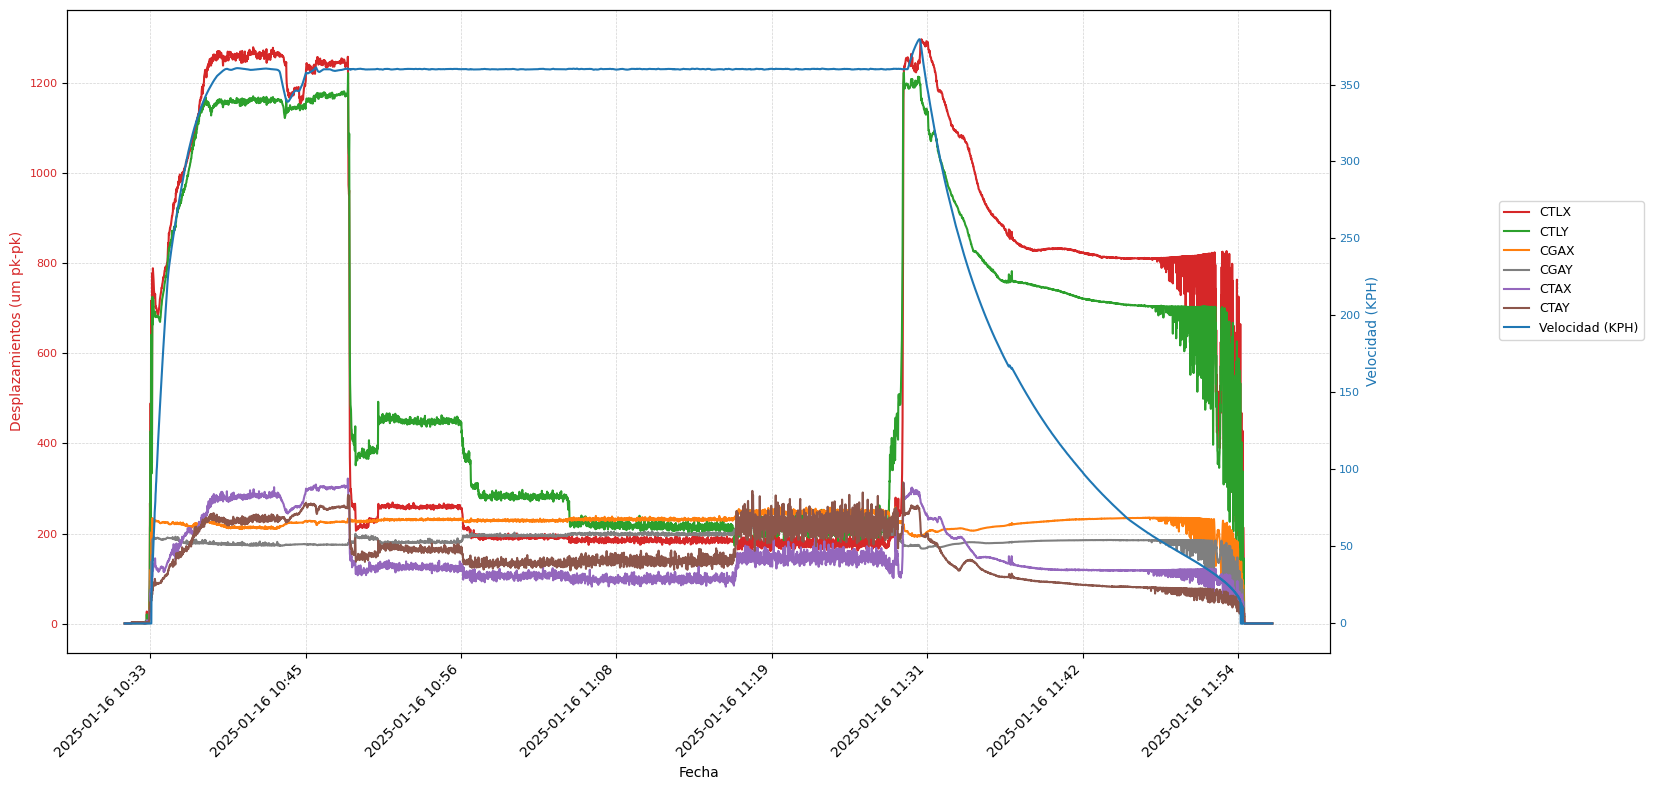

In [ ]:
plot_data(df_test_mv)

In [ ]:
processor = TurbineDataAnalyzer()
data_frames = []
for file_path in file_paths:
        df, _ = processor.process(file_path=file_path, scale_method = 'minmax', trim_percentage = 0.08)
        if df is not None:
            data_frames.append((file_path, df))
        else:
            print(f"Error procesando el archivo: {file_path}")

In [ ]:
processor = TurbineDataAnalyzer()

In [ ]:
file_paths[0]

'/content/drive/MyDrive/desbalanceo/data/desbalanceo/1_arranqueParadaDesblnCILCIP.csv'

In [ ]:
processor.load_data(df = df)

In [ ]:
processor.scale_displacements(trim_percentage=0.08)

In [ ]:
df = processor_2.process_file(file_paths[0])

In [ ]:
df['KPH'].head()

,KPH
0,0.000000
1,0.000000
2,36.430978
3,52.022370
4,63.515588


In [ ]:
df_test = df.copy()

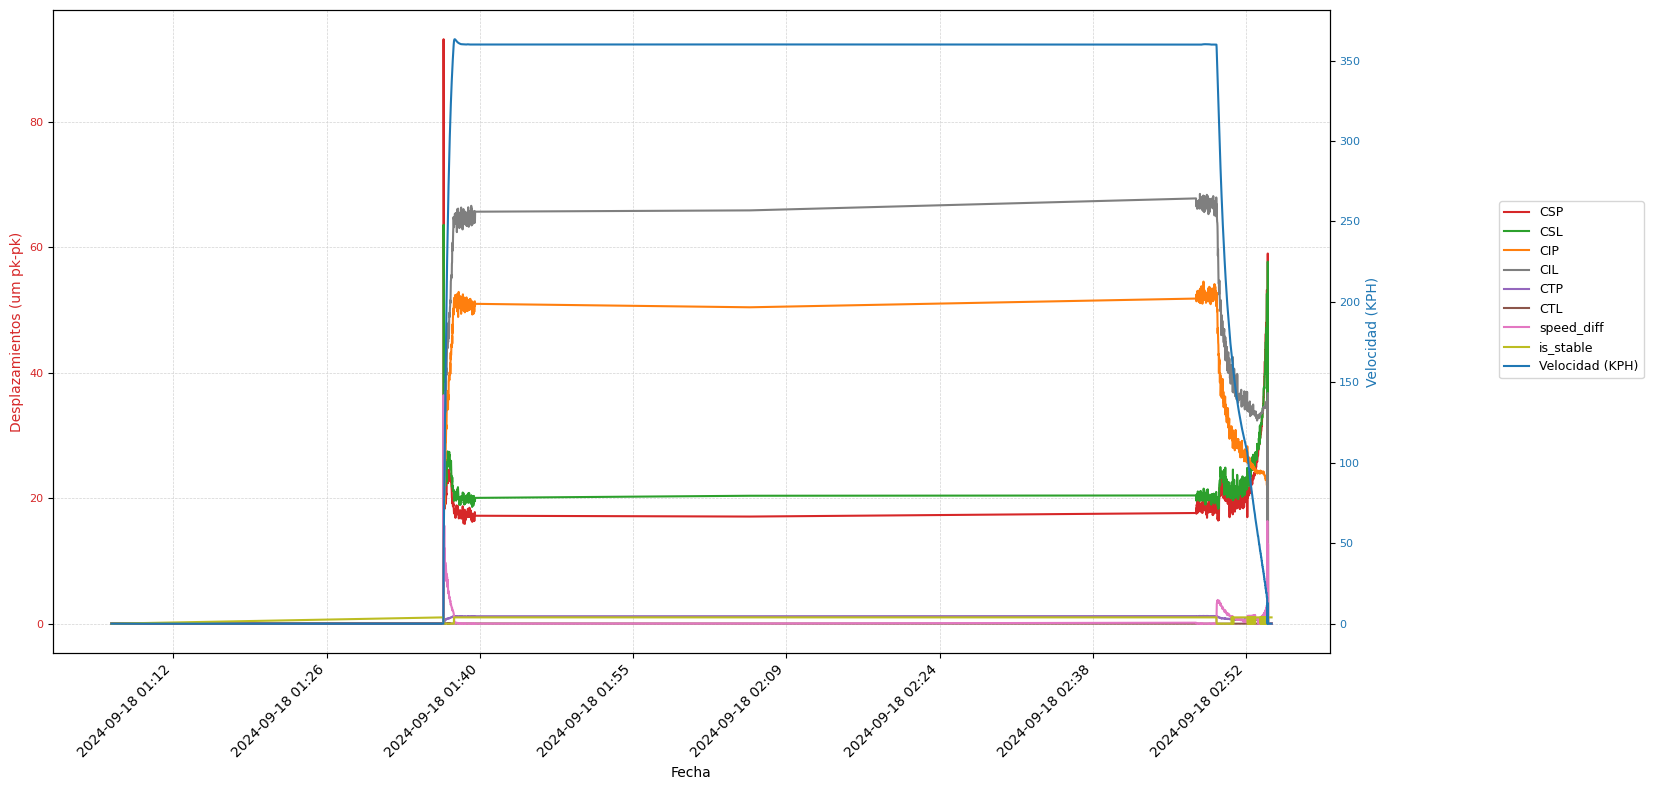

In [ ]:
plot_data(df_test)

In [ ]:
df_test['speed_diff'] = df_test['KPH'].diff().abs()
df_test['speed_diff'].head()

,speed_diff
0,NaN
1,0.000000
2,36.430978
3,15.591391
4,11.493218


In [ ]:
df_test['is_stable'] = df_test['speed_diff'] < 1.0
df_test['is_stable'].head()

,is_stable
0,False
1,True
2,False
3,False
4,False


In [ ]:
df_test['is_stable'].shift().head()

,is_stable
0,NaN
1,False
2,True
3,False
4,False


In [ ]:
 if df_test['is_stable'][20] != df_test['is_stable'].shift()[0]:
    print('ok')

ok


In [ ]:
df_test['change_in_stability'] = df_test['is_stable'] != df_test['is_stable'].shift()
df_test['change_in_stability'].head()

,change_in_stability
0,True
1,True
2,True
3,False
4,False


In [ ]:
df_test['stable_block_cumsumm'] = df_test['change_in_stability'].cumsum()
df_test['stable_block_cumsumm'].head()

,stable_block_cumsumm
0,1
1,2
2,3
3,3
4,3


In [ ]:
df_test['stable_block'] = df_test['stable_block_cumsumm'] * df_test['is_stable']
df_test['stable_block'].head()

,stable_block
0,0
1,2
2,0
3,0
4,0


In [ ]:
stable_blocks = df_test[df_test['stable_block']> 0].groupby('stable_block').size()
stable_blocks

,0
stable_block,
2,1
4,237
6,2
8,2
10,2
12,80
14,1
16,1
18,1


In [ ]:
stable_blocks.max()

237

In [ ]:
longest_stable_block = stable_blocks.idxmax()
longest_stable_block

np.int64(4)

In [ ]:
stable_region = df_test[df_test['stable_block'] == longest_stable_block]
stable_region.head()

,Fecha,KPH,CSP,CSL,CIP,CIL,CTP,CTL,speed_diff,is_stable,change_in_stability,stable_block_cumsumm,stable_block
61,2024-09-18 01:38:22,362.275088,17.587937,19.592477,51.953834,63.234153,1.147878,0.023821,0.916379,True,True,4,4
62,2024-09-18 01:38:23,362.822761,17.748442,19.805277,51.397960,64.537844,1.173164,0.022527,0.547674,True,False,4,4
63,2024-09-18 01:38:24,363.130182,18.134788,20.607964,50.624329,64.158262,1.169011,0.022849,0.307421,True,False,4,4
64,2024-09-18 01:38:25,363.262094,17.985862,19.951032,50.356082,64.266646,1.171099,0.026875,0.131911,True,False,4,4
65,2024-09-18 01:38:26,363.284088,17.548098,21.084487,50.878580,65.117878,1.182374,0.025115,0.021995,True,False,4,4


In [ ]:
nominal_speed = stable_region['KPH'].mean()
nominal_speed

np.float64(360.3086965179384)

In [ ]:
nominal_speed_two = stable_region['KPH'].max()
nominal_speed_two

363.28408815693876

In [ ]:
below_threshold = df_test['KPH'] < 0.95 * nominal_speed
below_threshold.head()

,KPH
0,True
1,True
2,True
3,True
4,True


In [ ]:
len(df_test)

609

In [ ]:
below_threshold.iloc[0]

np.True_

In [ ]:
min_consecutive = 3
for i in range(len(df_test) - min_consecutive + 1):
    if below_threshold.iloc[i]:
        if all(df_test['KPH'].iloc[i+j] < df_test['KPH'].iloc[i+j-1] for j in range(1,min_consecutive)):
          print(f"Inicio de caida: {df_test.index[i]}")
          index_caida = df_test.index[i]
          break


Inicio de caida: 303


In [ ]:
df_caida = df_test.loc[index_caida:].copy()
df_caida.head()

,Fecha,KPH,CSP,CSL,CIP,CIL,CTP,CTL,speed_diff,is_stable,change_in_stability,stable_block_cumsumm,stable_block
303,2024-09-18 02:50:07,341.432880,16.631301,19.410041,48.376276,63.375287,1.140206,0.021208,3.419480,False,False,5,0
304,2024-09-18 02:50:08,337.647721,16.808828,18.785336,46.268683,61.775593,1.113138,0.021800,3.785159,False,False,5,0
305,2024-09-18 02:50:09,334.122233,17.286127,19.856674,47.171147,58.686018,1.058699,0.022527,3.525488,False,False,5,0
306,2024-09-18 02:50:10,330.578512,17.670213,19.157926,45.849353,59.747029,1.078149,0.018983,3.543721,False,False,5,0
307,2024-09-18 02:50:11,326.997752,16.440324,18.923897,44.799657,58.074427,1.048712,0.024584,3.580761,False,False,5,0


In [ ]:
for i in range(1,min_consecutive):
  print(i)

1
2


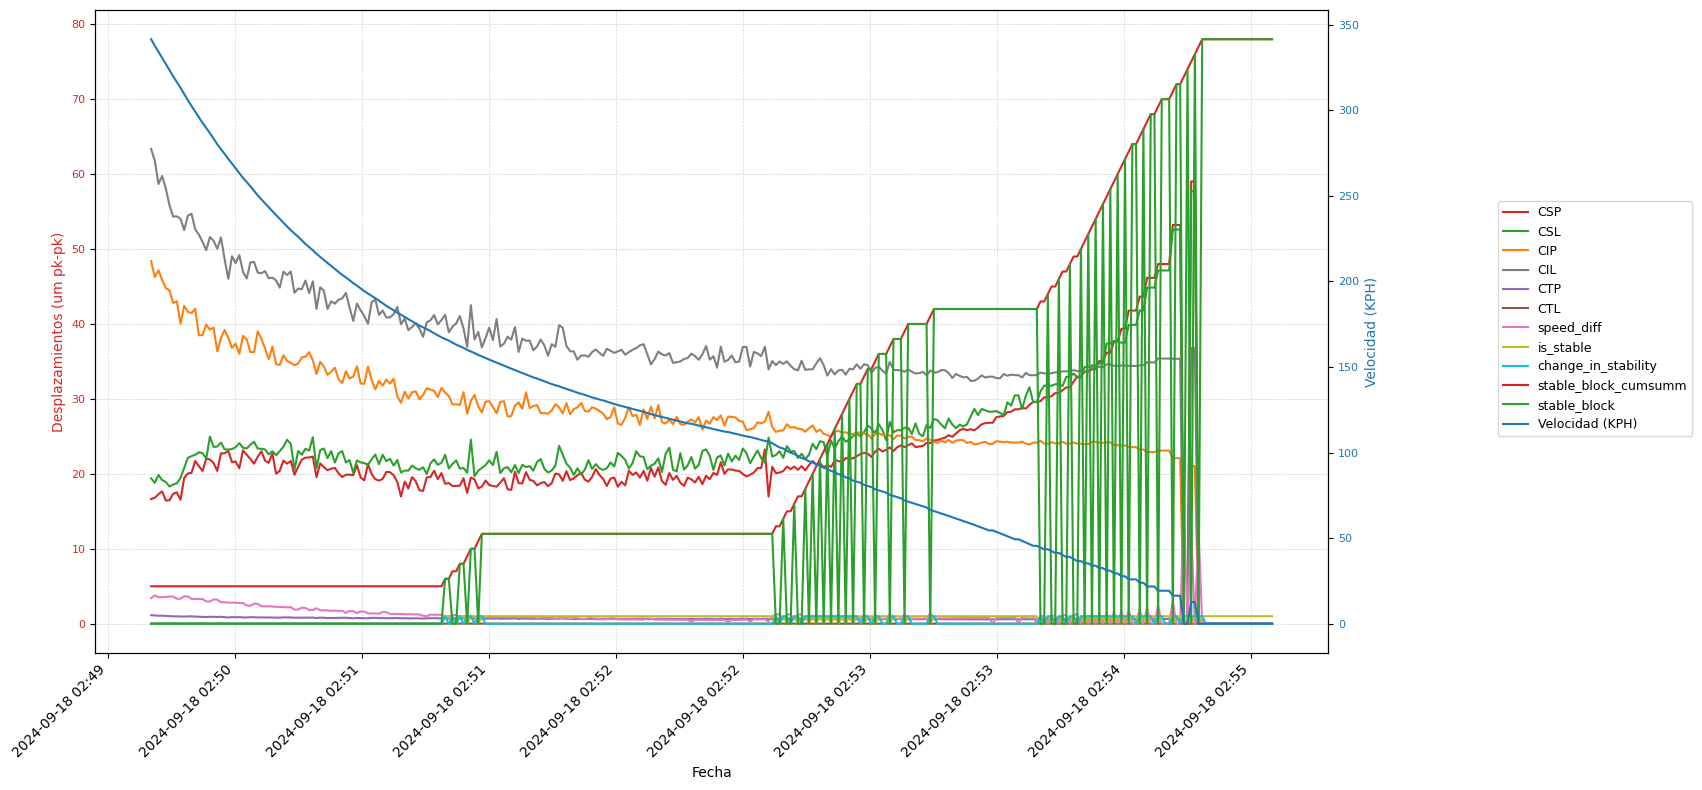

In [ ]:
plot_data(df_caida)

In [ ]:
df_preprocessed, nominal_speed = processor.process(df = df, scale_method = 'minmax', trim_percentage = 0.08)

In [ ]:
df_preprocessed.head()

,Fecha,KPH,CSP,CSL,CIP,CIL,CTP,CTL
303,2024-09-18 02:50:07,1.000000,0.281750,0.336216,1.000000,1.000000,1.000000,0.862656
304,2024-09-18 02:50:08,0.988914,0.284757,0.325395,0.956433,0.974758,0.976261,0.886761
305,2024-09-18 02:50:09,0.978588,0.292843,0.343952,0.975088,0.926008,0.928515,0.916315
306,2024-09-18 02:50:10,0.968209,0.299350,0.331849,0.947765,0.942750,0.945574,0.772150
307,2024-09-18 02:50:11,0.957722,0.278515,0.327795,0.926067,0.916358,0.919757,1.000000


In [ ]:
file_path_three = '/content/drive/MyDrive/tests/unprocessed/Histórico, Tendencia_ UNIDAD 1 (1).csv'

In [ ]:
file_path_four = '/content/drive/MyDrive/tests/unprocessed/Histórico, Tendencia_ UNIDAD 1 MUNICIPAL.csv'

In [ ]:
df_preprocessed_three, _ = processor.process(file_path=file_path_three, scale_method = 'minmax', trim_percentage = 0.08)

In [ ]:
processor_2 = DataProcessor()

In [ ]:
processor = TurbineDataAnalyzer()

In [ ]:
df_preprocessed_with_fpt = processor_2.process_file(file_path_three)
df_preprocessed_with_fpt.head()

,Fecha,KPH,CLEX,CLEY,CLAX,CLAY
0,2024-12-12 13:12:08,899.673667,34.738469,32.343417,24.346999,20.123116
1,2024-12-12 13:12:09,899.673667,34.709200,32.500856,24.500008,20.272818
2,2024-12-12 13:12:10,899.598394,34.880576,32.350895,23.875275,20.709024
3,2024-12-12 13:12:11,899.673667,34.641974,32.428697,23.624697,20.044267
4,2024-12-12 13:12:12,899.673667,35.018764,32.749312,23.532925,20.562404


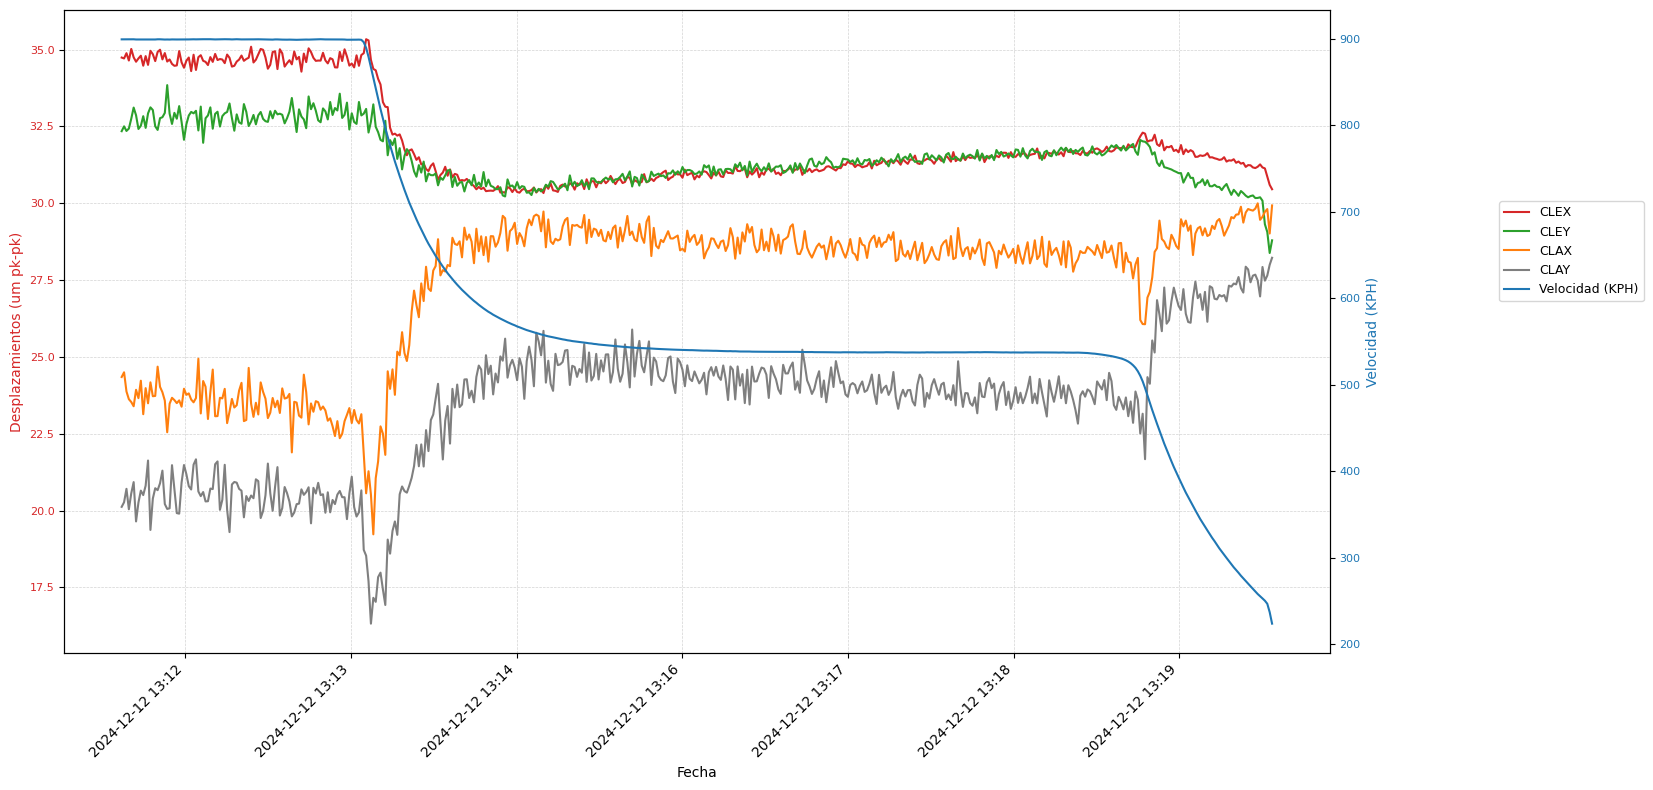

In [ ]:
plot_data(df_preprocessed_with_fpt)

In [ ]:
df_preprocessed_with_fpt_two, nominal_speed_with_fpt = processor.process(file_path= file_path_three ,scale_method = 'minmax')

In [ ]:
processor.load_data(df = df_preprocessed_with_fpt)
processor.identify_nominal_speed()
processor.cut_data()

In [ ]:
df_preprocessed_with_fpt_three = processor.df_caida
df_preprocessed_with_fpt_three.head()

,Fecha,KPH,CLEX,CLEY,CLAX,CLAY
106,2024-12-12 13:13:54,842.531646,34.323873,32.487734,21.054304,17.032793
107,2024-12-12 13:13:55,830.477458,34.045352,32.311915,21.602781,17.837198
108,2024-12-12 13:13:56,818.981605,33.862073,32.061169,22.741784,17.982149
109,2024-12-12 13:13:57,807.766990,33.289289,32.013919,22.501004,17.435664
110,2024-12-12 13:13:58,796.956071,33.138398,32.681904,21.814086,16.930575


In [ ]:
nominal_speed = processor.nominal_speed
nominal_speed

np.float64(899.5558147822294)

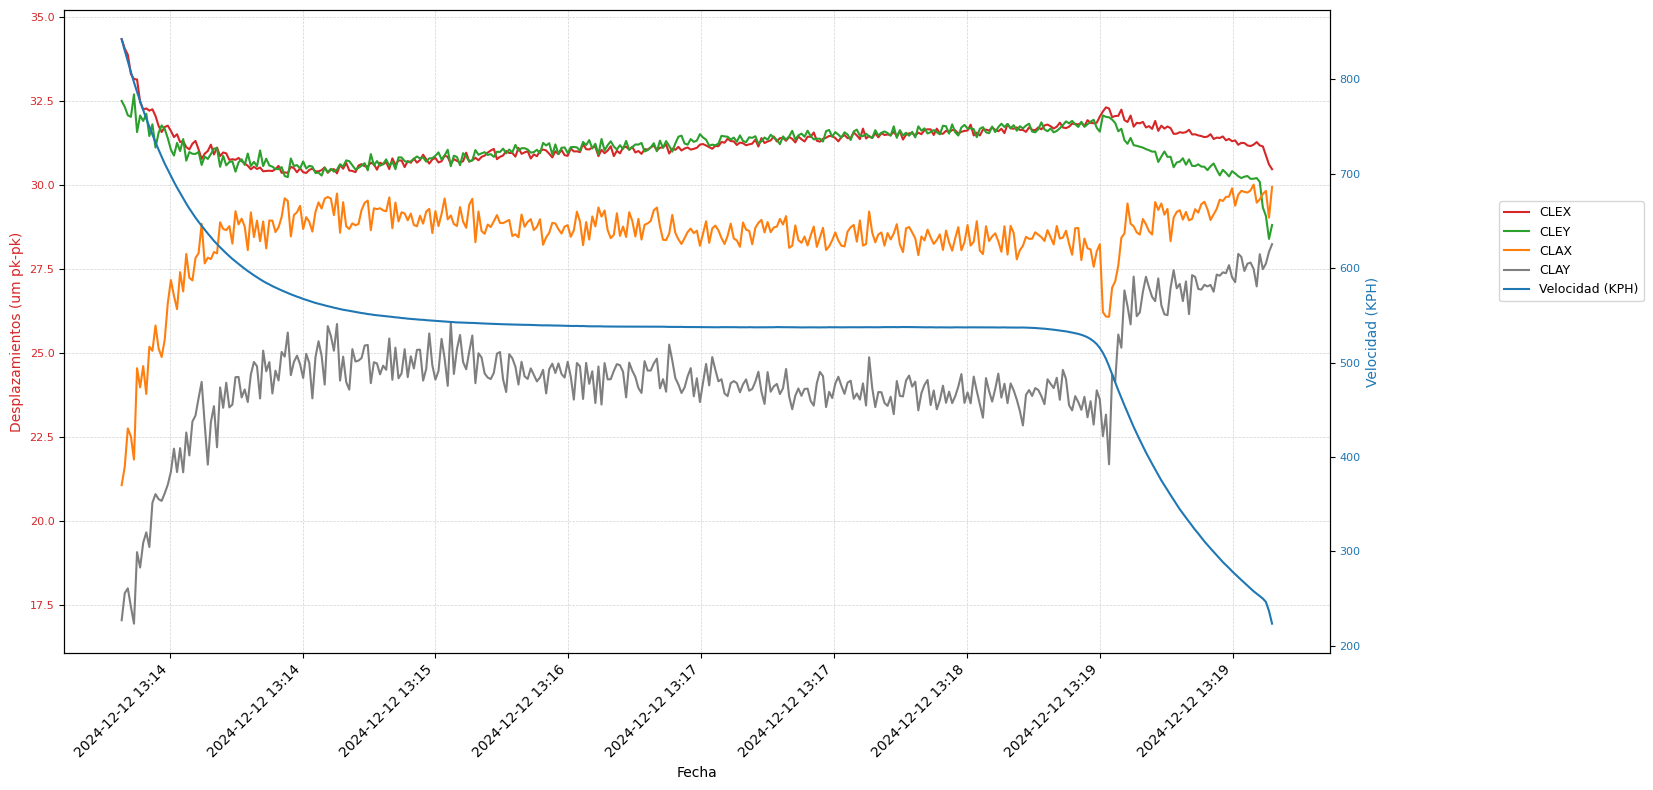

In [ ]:
plot_data(df_preprocessed_with_fpt_three)

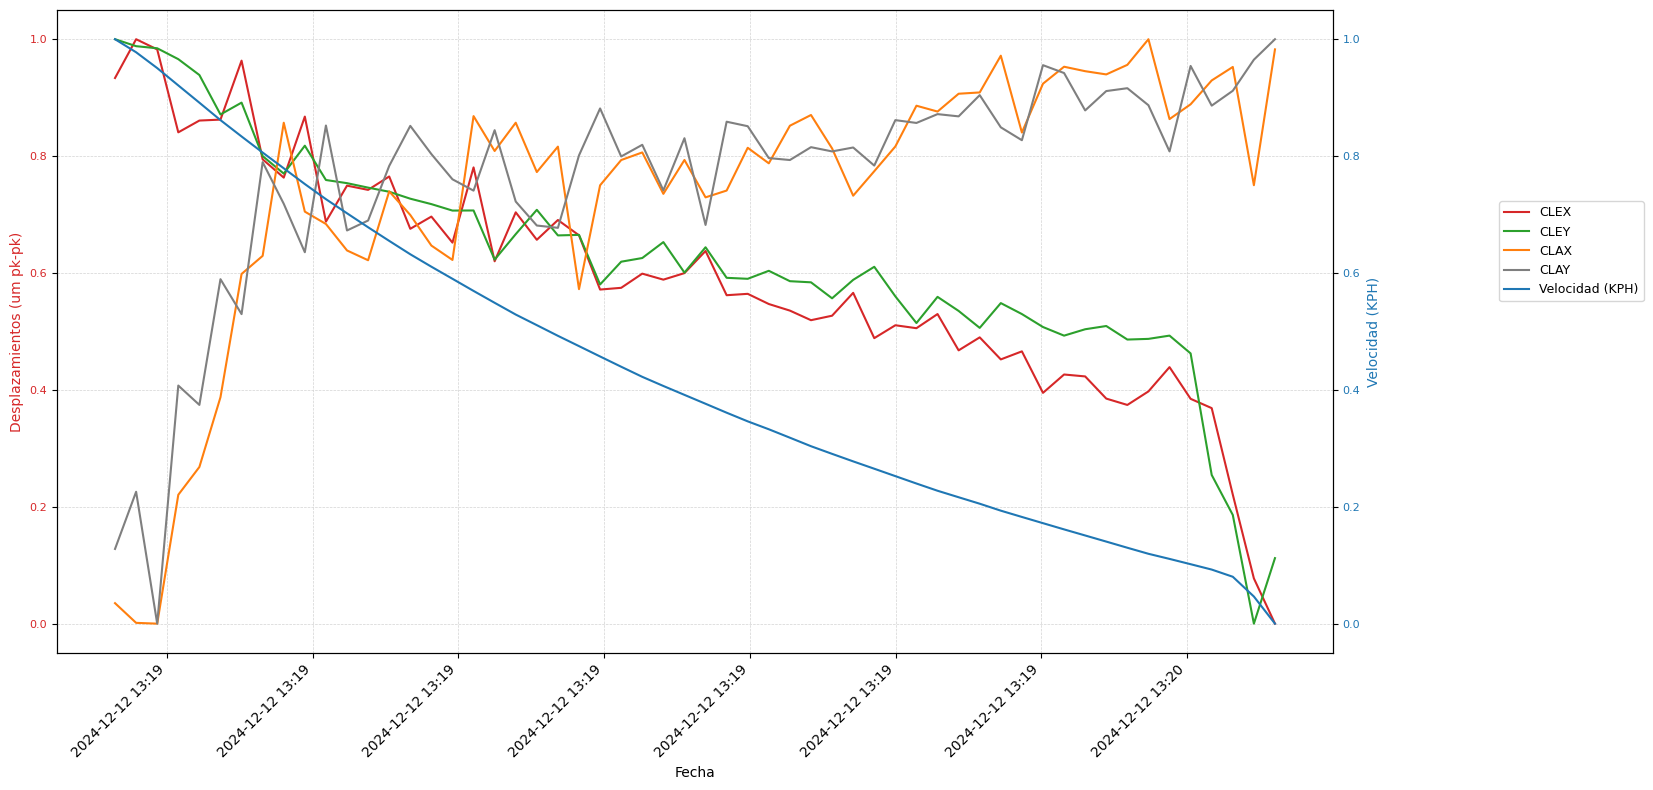

In [ ]:
plot_data(df_preprocessed_with_fpt_two)

In [ ]:
scaler = MinMaxScaler()
df_preprocessed_three[df_preprocessed_three.columns[1:]] = scaler.fit_transform(df_preprocessed_three[df_preprocessed_three.columns[1:]])

In [ ]:
df_preprocessed_four = processor_2.process_file(file_path_four)

In [ ]:
df_preprocessed_four[df_preprocessed_four.columns[1:]] = scaler.fit_transform(df_preprocessed_four[df_preprocessed_four.columns[1:]])

In [ ]:
df_preprocessed_three = processor_2.process_file(file_path_three)

In [ ]:
df_preprocessed_three = df_preprocessed_three[df_preprocessed_three['KPH'] >= 0.43]

In [ ]:
df_preprocessed_three = df_preprocessed_three[df_preprocessed_three['KPH'] <= 0.97]

In [ ]:
df_preprocessed_three.to_csv('/content/drive/MyDrive/tests/Histórico, Tendencia_ UNIDAD 1 (1)_preprocessed.csv', index=False)

In [ ]:
file_path = '/content/drive/MyDrive/desbalanceo/tests/PROX - FILTRADA 1X.csv'
file_path_list = [file_path]

In [ ]:
processor_2 = DataProcessor()
df_preprocessed = processor_2.process_file(file_path)

In [ ]:
df_preprocessed.columns[1:]

Index(['KPH', 'CGSX', 'CGSY', 'CGIX', 'CGIY', 'CGTX', 'CGTY'], dtype='object')

In [ ]:
scaler = MinMaxScaler()
df_preprocessed[df_preprocessed.columns[1:]] = scaler.fit_transform(df_preprocessed[df_preprocessed.columns[1:]])

In [ ]:
df_filter = df_preprocessed[df_preprocessed['KPH'] >= 0.18]

In [ ]:
df_filter_2 = df_filter[df_filter['KPH'] <= 0.91]

In [ ]:
ruta_guardado = "/content/drive/MyDrive/tests/PROX - FILTRADA 1X_preprocesada2.csv"

In [ ]:
df_filter_2.to_csv(ruta_guardado, index=False)

In [ ]:
procesar_y_guardar_archivos()

In [ ]:
df_preprocessed['Fecha']

,Fecha
0,2022-03-17 10:52:24
1,2022-03-17 10:52:25
2,2022-03-17 10:52:26
3,2022-03-17 10:52:27
4,2022-03-17 10:52:28
...,...
424,2022-03-17 10:59:28
425,2022-03-17 10:59:29
426,2022-03-17 10:59:30
427,2022-03-17 10:59:31


In [ ]:
processor = TurbineDataAnalyzer()
df_test, _ = processor.process(file_path=file_path, scale_method = 'minmax', trim_percentage = 0)

In [ ]:
procesar_y_guardar_archivos(file_path_list)

El archivo PROX - FILTRADA 1X es un archivo de test y se guardará en la ruta /content/drive/MyDrive/tests


[('/content/drive/MyDrive/desbalanceo/tests/PROX - FILTRADA 1X.csv',
                    Fecha       KPH      CGSX      CGSY      CGIX      CGIY  \
  299 2022-03-17 10:57:23  1.000000  0.614318  0.650176  0.889345  0.962231   
  300 2022-03-17 10:57:24  0.997637  0.665853  0.623110  0.894860  0.949998   
  301 2022-03-17 10:57:25  0.993178  0.581658  0.650068  0.890992  0.985464   
  302 2022-03-17 10:57:26  0.991080  0.578639  0.658361  0.891587  1.000000   
  303 2022-03-17 10:57:27  0.986564  0.585147  0.688896  0.850662  0.986304   
  ..                  ...       ...       ...       ...       ...       ...   
  416 2022-03-17 10:59:20  0.222762  0.932008  0.920969  0.827584  0.862396   
  417 2022-03-17 10:59:21  0.222762  0.932008  0.920969  0.827584  0.862396   
  418 2022-03-17 10:59:22  0.170173  1.000000  0.937995  0.869041  0.877202   
  419 2022-03-17 10:59:23  0.170173  1.000000  0.937995  0.869041  0.877202   
  420 2022-03-17 10:59:24  0.170173  1.000000  0.937995  0.869

In [ ]:
filtered_df = data_frames[21][1][data_frames[21][1]['Fecha'] <= '2024-02-27 :06']
data_frames[21] = (data_frames[21][0], filtered_df)

In [ ]:
data_frames[9][0]

'/content/drive/MyDrive/desbalanceo/data/desbalanceo/4_arranqueParadaDesblnCSLCSPCTP.csv'

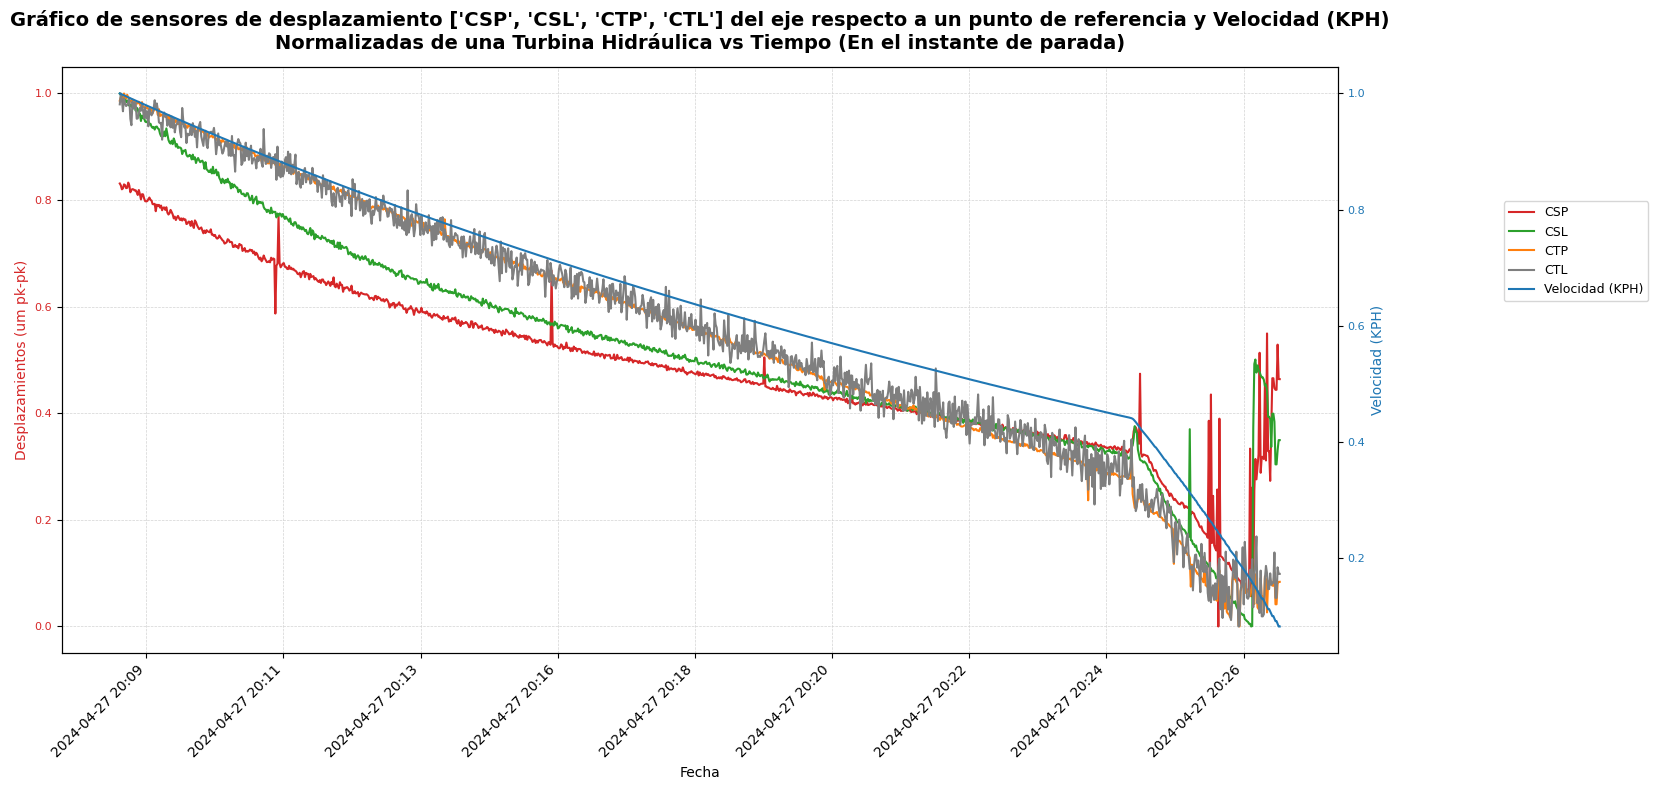

In [ ]:
plot_data(data_frames[9][1])

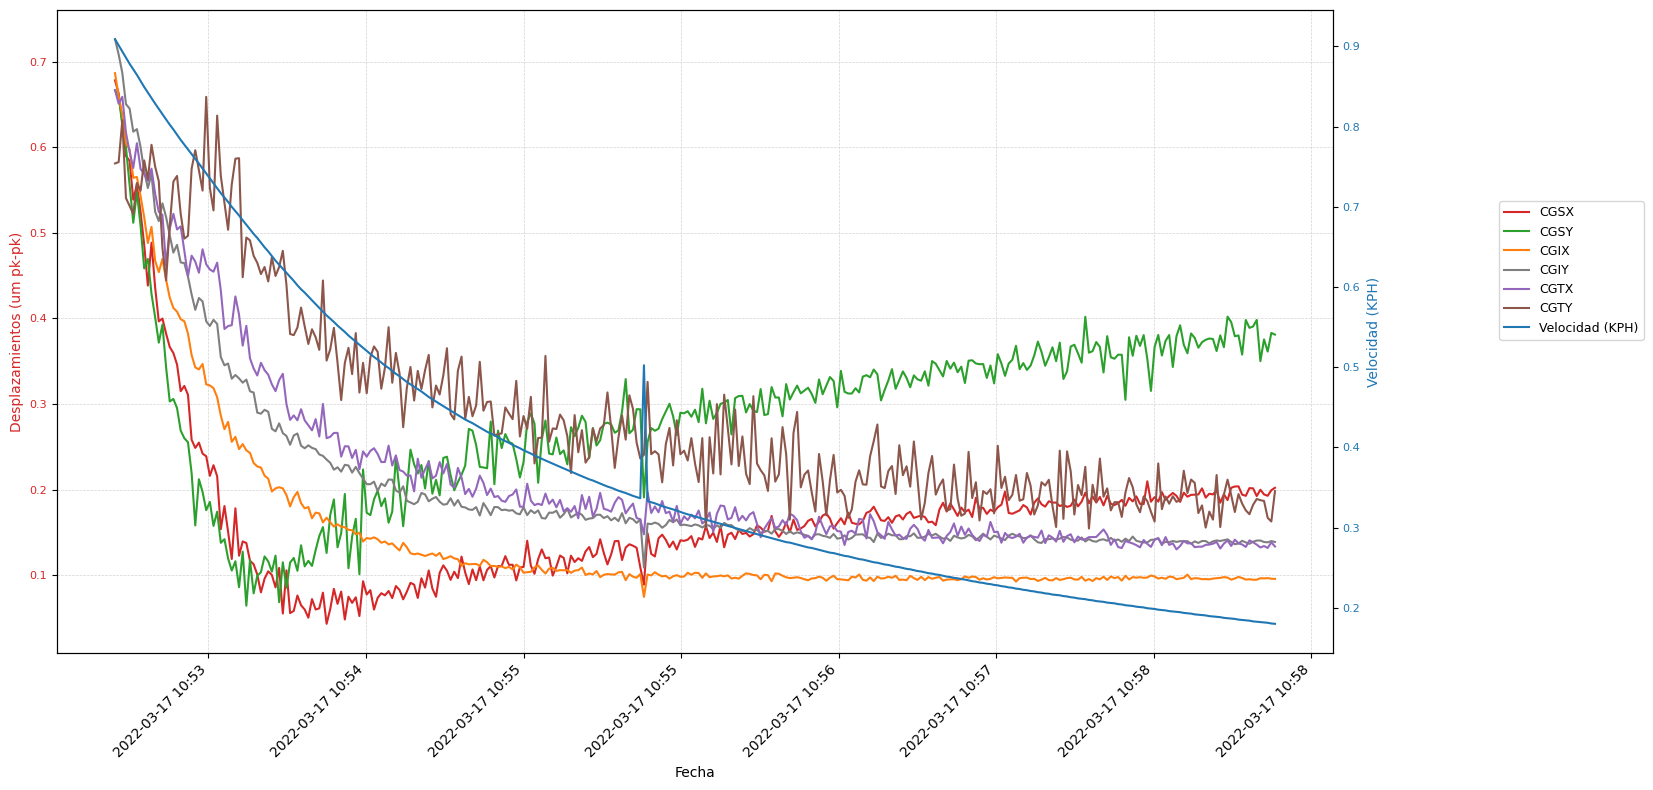

In [ ]:
plot_data(df_filter_2)

In [ ]:
file_path_test = '/content/drive/MyDrive/tests/unprocessed/FILTRADA 1X.csv'

In [ ]:
df_test_two, _ = processor.process(file_path=file_path_test, scale_method = 'minmax', trim_percentage = 0.08)

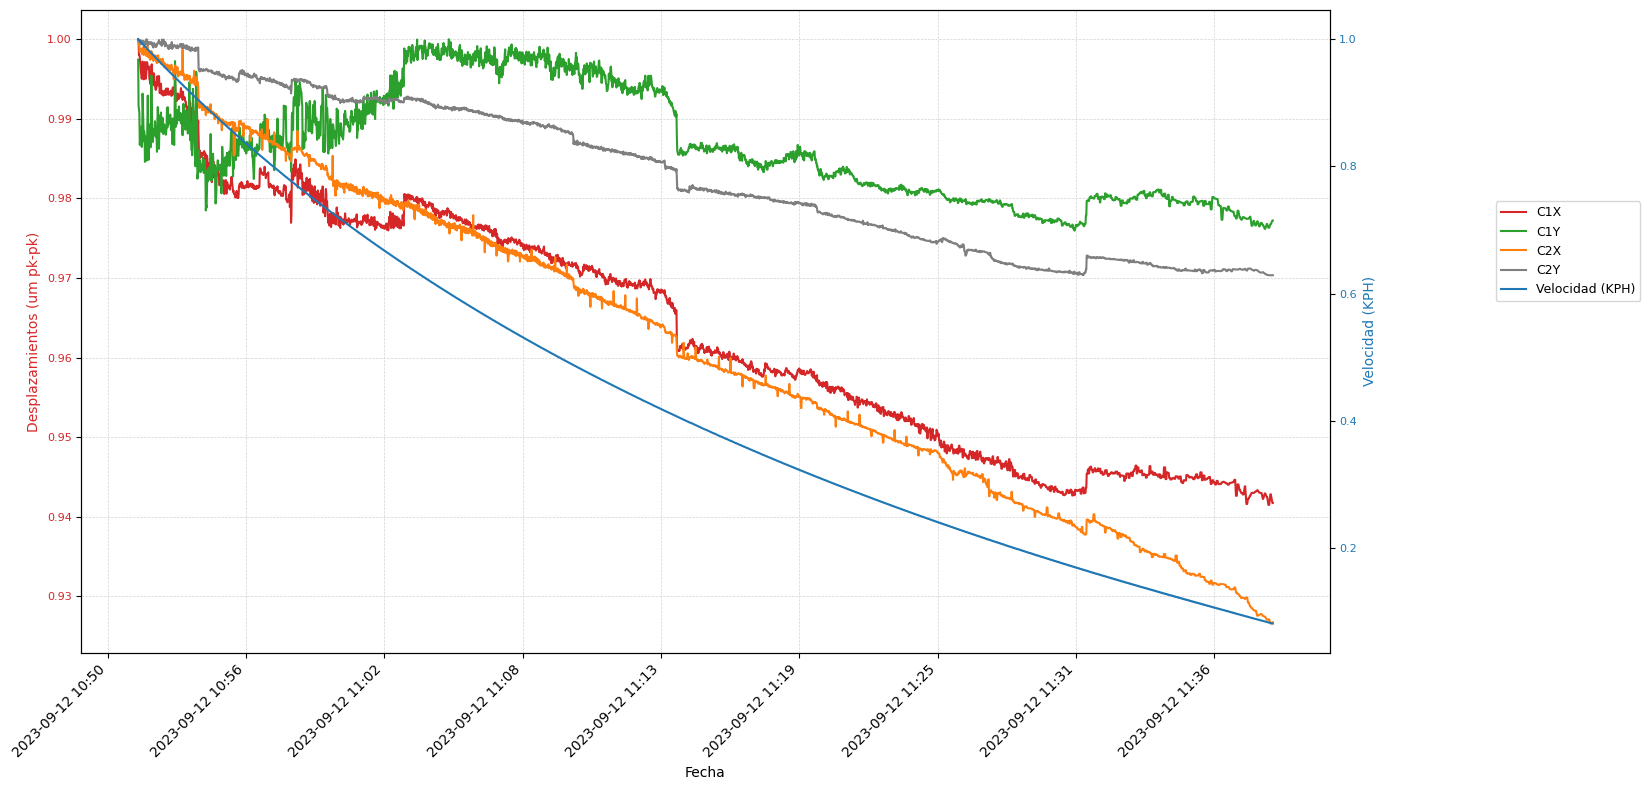

In [ ]:
plot_data(df_test_two)

In [ ]:
procesar_y_guardar_archivos([file_path_test])

El archivo FILTRADA 1X es un archivo de test y se guardará en la ruta /content/drive/MyDrive/tests


[('/content/drive/MyDrive/tests/unprocessed/FILTRADA 1X.csv',
                     Fecha       KPH       C1X       C1Y       C2X       C2Y
  1571 2023-09-12 10:52:09  1.000000  1.000000  0.997436  1.000000  0.999849
  1572 2023-09-12 10:52:10  0.999222  0.999935  0.991588  0.999514  0.999799
  1573 2023-09-12 10:52:11  0.998640  0.998036  0.991238  0.999204  0.999694
  1574 2023-09-12 10:52:12  0.997961  0.998065  0.990775  0.999153  0.999747
  1575 2023-09-12 10:52:13  0.997090  0.997761  0.986724  0.998380  0.999760
  ...                  ...       ...       ...       ...       ...       ...
  4397 2023-09-12 11:39:15  0.082466  0.941496  0.976316  0.927116  0.970357
  4400 2023-09-12 11:39:18  0.081644  0.942825  0.976761  0.926585  0.970339
  4401 2023-09-12 11:39:19  0.081644  0.942825  0.976761  0.926585  0.970339
  4405 2023-09-12 11:39:23  0.080818  0.941731  0.977225  0.926750  0.970354
  4406 2023-09-12 11:39:24  0.080818  0.941731  0.977225  0.926750  0.970354
  
  [2778 row

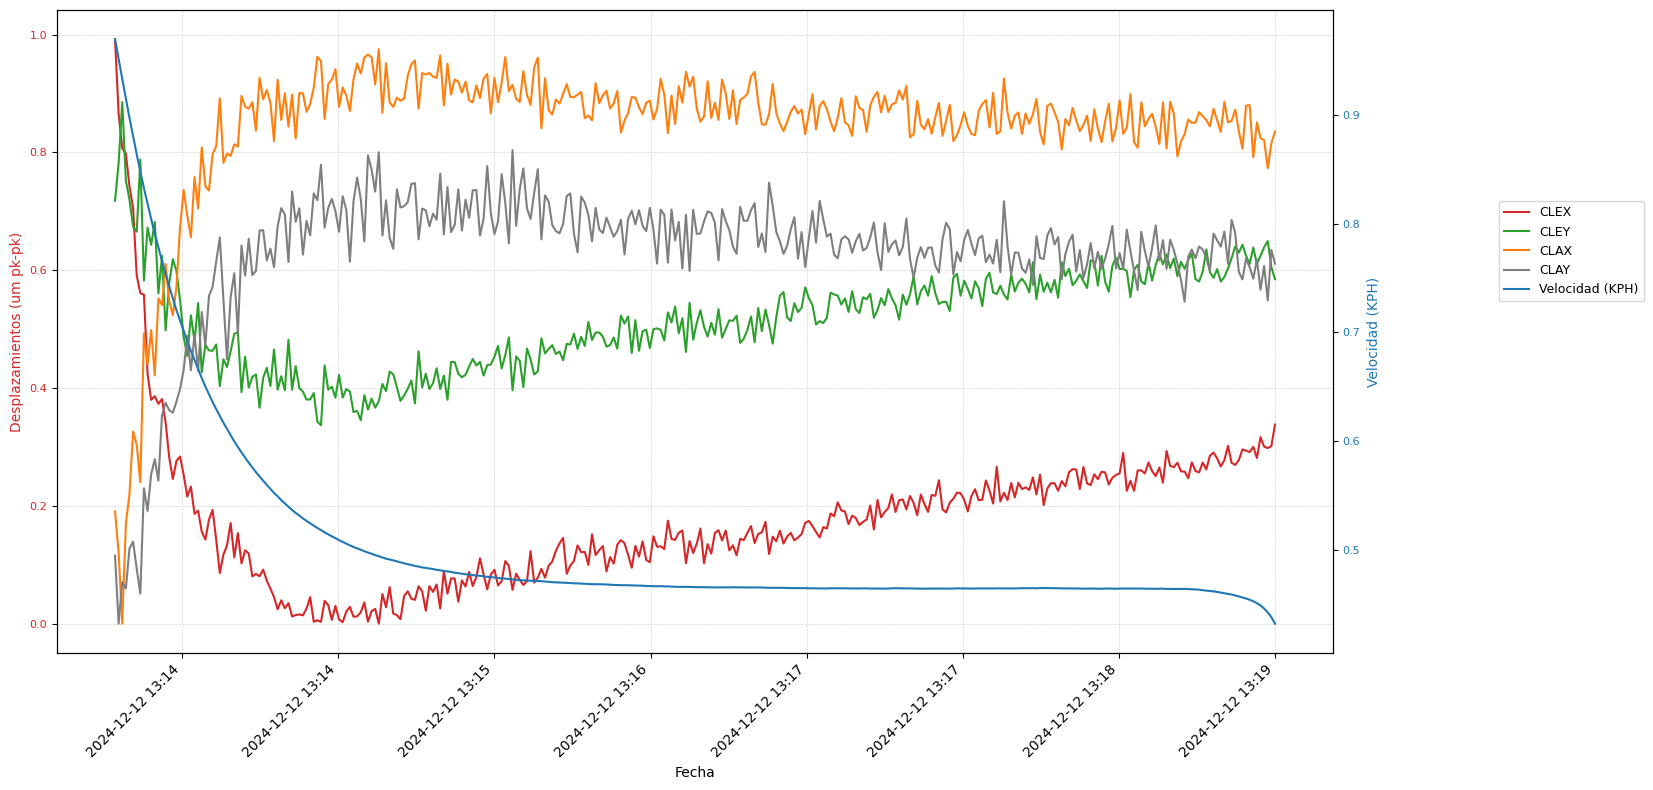

In [ ]:
plot_data(df_preprocessed_three)

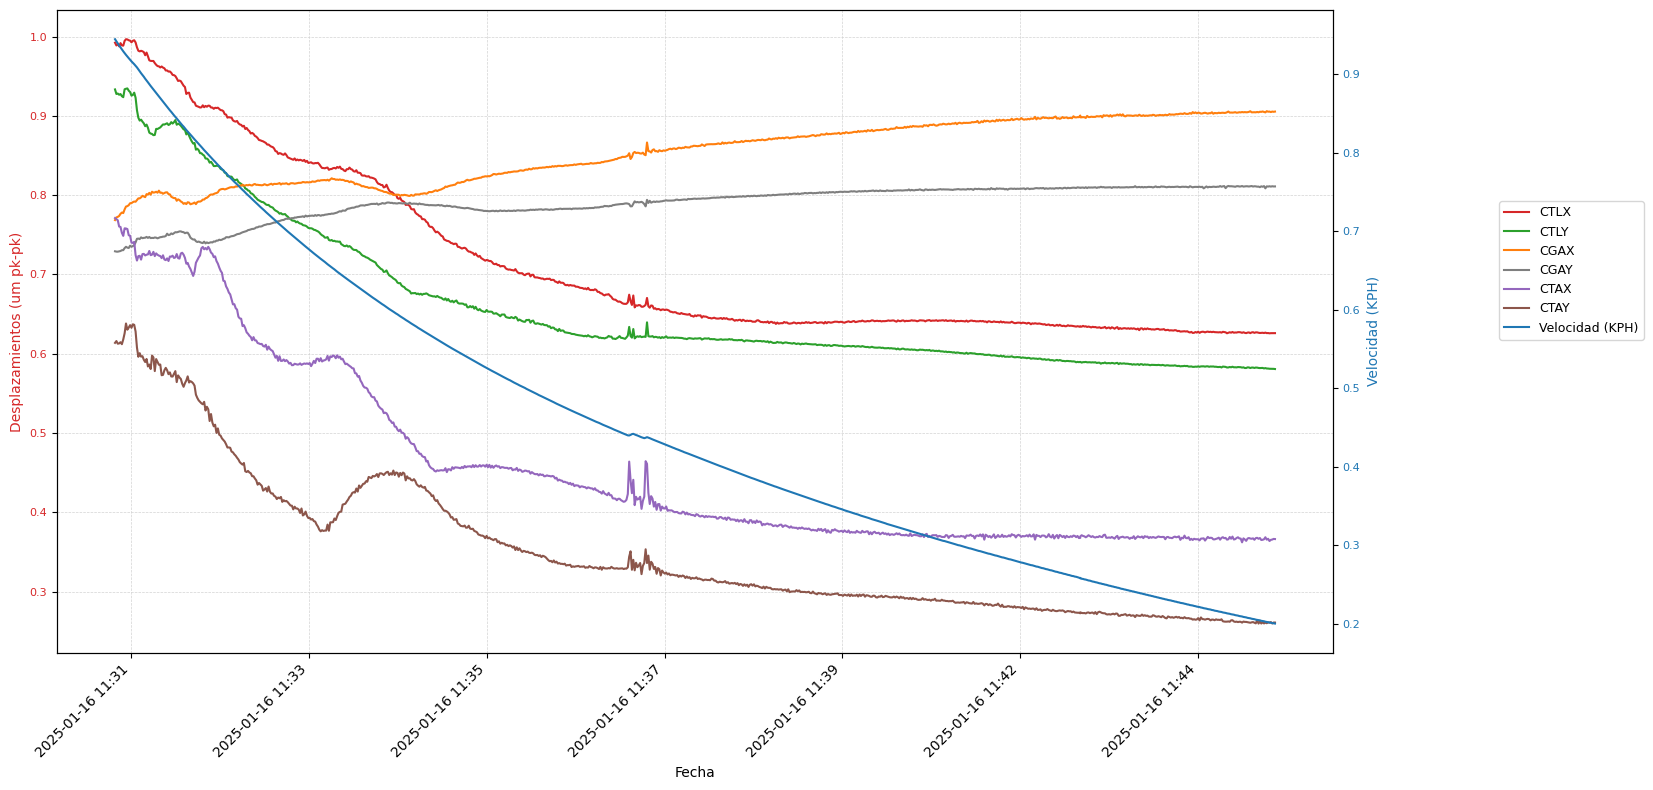

In [ ]:
plot_data(df_preprocessed_four)

In [ ]:
df_preprocessed_four.to_csv('/content/drive/MyDrive/tests/Histórico, Tendencia_ UNIDAD 1 MUNICIPAL_preprocessed.csv', index=False)

In [ ]:
df_preprocessed_four = df_preprocessed_four[df_preprocessed_four['Fecha'] >= '2025-01-16 11:31']

In [ ]:
df_preprocessed_four['Fecha']

,Fecha
0,2025-01-16 10:31:43
1,2025-01-16 10:31:44
2,2025-01-16 10:31:45
3,2025-01-16 10:31:46
4,2025-01-16 10:31:47
...,...
5100,2025-01-16 11:56:42
5101,2025-01-16 11:56:43
5102,2025-01-16 11:56:44
5103,2025-01-16 11:56:45


In [ ]:
df_preprocessed_four = df_preprocessed_four[df_preprocessed_four['KPH'] >= 0.2]